In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from malaya_speech.torch_model.vits.model_infer import SynthesizerTrn
from malaya_boilerplate.train.config import HParams
import json

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [3]:
config = '/home/ubuntu/dev/malaya-speech/malay_vits/multispeaker-clean-v4.json'

In [4]:
with open(config) as fopen:
    hps = HParams(**json.load(fopen))

In [5]:
from malaya_speech.utils.text import TTS_SYMBOLS
import torch

In [6]:
model = SynthesizerTrn(len(TTS_SYMBOLS),
                                   hps.data.filter_length // 2 + 1,
                                   hps.train.segment_size // hps.data.hop_length,
                                   n_speakers=hps.data.n_speakers,
                                   **hps.model)

In [7]:
_ = model.eval()

In [41]:
!ls /home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_*.pth

/home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_155000.pth
/home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_160000.pth
/home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_165000.pth
/home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_170000.pth


In [49]:
pth = '/home/ubuntu/dev/malaya-speech/malay_vits/logs/out-v3/G_165000.pth'

In [50]:
model.load_state_dict(torch.load(pth, map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

In [51]:
from malaya_speech.torch_model.vits.commons import intersperse
import malaya_speech

In [52]:
normalizer = malaya_speech.utils.text.TextIDS(pad_to = None, understand_punct=False,
    is_lower=False)

In [58]:
text = """
husein comel busuk
"""

In [67]:
t, ids = normalizer.normalize(text, normalize = False, add_fullstop = True)
print(t)
ids = intersperse(ids, 0)
ids = torch.LongTensor(ids)
ids_lengths = torch.LongTensor([ids.size(0)])
ids = ids.unsqueeze(0)
audio = model.infer(
    ids,
    ids_lengths,
    noise_scale=0.1,
    noise_scale_w=0.1,
    length_scale=1.0,
    sid=torch.tensor([1]),
)

husein comel busuk .


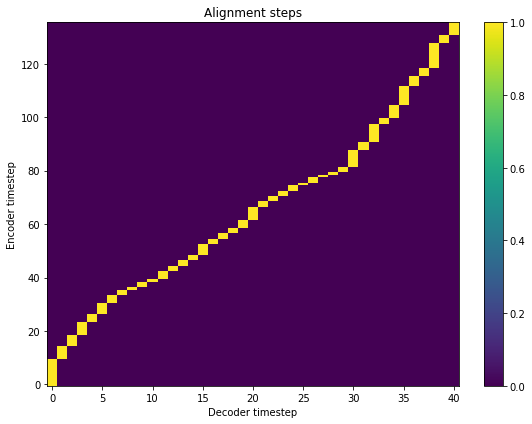

In [68]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    audio[1][0,0].detach().numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [69]:
y = audio[0][0,0].detach().numpy()

In [70]:
import IPython.display as ipd
ipd.Audio(y, rate = 22050)

In [72]:
torch.save(model.state_dict(), 'multispeaker-noisy.pth')

In [73]:
from huggingface_hub import create_repo, upload_file

In [74]:
# create_repo('mesolitica/VITS-multispeaker-noisy')

In [75]:
upload_file(path_or_fileobj='multispeaker-noisy.pth',
        path_in_repo='model.pth',
        repo_id='mesolitica/VITS-multispeaker-noisy')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

multispeaker-noisy.pth:   0%|          | 0.00/159M [00:00<?, ?B/s]

'https://huggingface.co/mesolitica/VITS-multispeaker-noisy/blob/main/model.pth'

In [76]:
upload_file(path_or_fileobj=config,
        path_in_repo='config.json',
        repo_id='mesolitica/VITS-multispeaker-noisy')

'https://huggingface.co/mesolitica/VITS-multispeaker-noisy/blob/main/config.json'